In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset='https://drive.google.com/drive/folders/1s1geXGVp13B2nn2LvDnNURItXY2M1qYi?usp=drive_link'

In [ ]:
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import matplotlib.image as mpimg
%matplotlib inline
from datetime import datetime
from tqdm.keras import TqdmCallback
from skimage import transform
import requests

# TensorFlow libraries
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
train_path = '/content/drive/MyDrive/Plantdisease'
batch_size = 32
img_height = 300 # Inception-ResNet V2 expects 300x300 images
img_width = 300
seed_train_validation = 1
shuffle_value = True
validation_split = 0.4

# Load training images
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed_train_validation,
    shuffle=shuffle_value
)

# Load validation images
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed_train_validation,
    shuffle=shuffle_value
)

Found 2509 files belonging to 5 classes.
Using 1506 files for training.
Found 2509 files belonging to 5 classes.
Using 1003 files for validation.


In [ ]:
class_names = train_ds.class_names

# Clean the class names if necessary (example: split on underscores)
# Use a conditional to check if the class name contains an underscore
class_names = [x.split('_')[1] if '_' in x else x for x in class_names]

# View class names
print("The target classes are: ", *class_names, sep=" ,")

The target classes are:  ,Gray Leaf Spot ,Leaf Blight ,Leaf Spot ,Stem Bleeding ,Yellowing


In [ ]:
# Rescaling images for the model
'''TensorFlow Hub's convention for image models is to expect float inputs in the [0, 1] range'''

normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to both train and validation datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))  # x—images, y—labels
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Enable buffered prefetching for performance improvement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2

# Load the Inception-ResNet V2 model as a feature extractor
feature_extractor_model = InceptionResNetV2(weights='imagenet', include_top=False, pooling='avg')



219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
# feature extraction layer
'''Create the feature extractor by wrapping the pre-trained model as a Keras layer with hub.KerasLayer. Use the trainable=False argument to freeze the variables, so that the training only modifies the new classifier layer'''
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_width, img_height, 3),
    trainable=False)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers

# Load the Inception-ResNet V2 model as a feature extractor
feature_extractor_model = InceptionResNetV2(weights='imagenet', include_top=False, pooling='avg')

# Create the feature extractor layer
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_width, img_height, 3),
    trainable=False
)

# Define the input layer explicitly
input_tensor = tf.keras.Input(shape=(img_width, img_height, 3))

# Pass the input tensor to the feature extractor layer
x = feature_extractor_layer(input_tensor)

# Add the classification layer
num_classes = len(class_names)
output_tensor = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [ ]:
# Directories for training and validation datasets
train_dir = '/content/drive/MyDrive/Plantdisease'
validation_dir = '/content/drive/MyDrive/leaf dataset'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,          # Normalize pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images
    shear_range=0.2,            # Shear angle in counter-clockwise direction
    zoom_range=0.2,             # Randomly zoom into images
    horizontal_flip=True,       # Randomly flip images horizontally
    width_shift_range=0.2,      # Randomly shift images horizontally (fraction of width)
    height_shift_range=0.2,     # Randomly shift images vertically (fraction of height)
    fill_mode='nearest'         # Fill points outside the boundaries
)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
# Load images from directory and apply augmentations
train_generator = train_datagen.flow_from_directory(
    train_dir,                # Replace with the path to your training dataset
    target_size=(299, 299),    # Inception-ResNet V2 expects 299x299 images
    batch_size=32,
    class_mode='binary'        # Use 'categorical' if you have more than 2 classes
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,            # Replace with the path to your validation dataset
    target_size=(299, 299),    # Inception-ResNet V2 expects 299x299 images
    batch_size=32,
    class_mode='binary'        # Use 'categorical' if you have more than 2 classes
)


Found 2509 images belonging to 5 classes.
Found 249 images belonging to 1 classes.


In [ ]:
# Load Inception-ResNet V2 model as a feature extractor, freezing its weights
inception_resnet_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers of the Inception-ResNet V2 model
for layer in inception_resnet_model.layers:
    layer.trainable = False

In [ ]:
# Create the final model
x = inception_resnet_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling for feature extraction
x = Dense(1024, activation='relu')(x)  # Add a dense layer for learning new features
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(len(class_names), activation='softmax')(x)  # Output layer with softmax for multi-class classification

# Define the model
model = Model(inputs=inception_resnet_model.input, outputs=output)

# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Load images from directory and apply augmentations
train_generator = train_datagen.flow_from_directory(
    train_dir,                   # Replace with your training dataset path
    target_size=(299, 299),       # Inception-ResNet V2 expects 299x299 images
    batch_size=32,
    class_mode='categorical'      # Use 'categorical' for multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,               # Replace with your validation dataset path
    target_size=(299, 299),       # Inception-ResNet V2 expects 299x299 images
    batch_size=32,
    class_mode='categorical'      # Use 'categorical' for multi-class classification
)


Found 2509 images belonging to 5 classes.
Found 249 images belonging to 1 classes.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2  # Import InceptionResNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define variables for paths and image parameters
train_path = '/content/drive/MyDrive/Plantdisease'  # Update with the correct path to your dataset

batch_size = 32
img_height = 300
img_width = 300
validation_split = 0.4
seed_train_validation = 1
shuffle_value = True

# Load training images
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed_train_validation,
    shuffle=shuffle_value
)

# Load validation images
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=seed_train_validation,
    shuffle=shuffle_value
)

# Cleaning the class names (optional step, based on the dataset structure)
class_names = train_ds.class_names
# Clean the class names if necessary (example: split on underscores)
# Use a conditional to check if the class name contains an underscore
class_names = [x.split('_')[1] if '_' in x else x for x in class_names]

# View class names
print("The target classes are: ", *class_names, sep=" ,")

# Rescale the images for the model (Normalize pixel values between 0 and 1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetching for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Load the Inception-ResNet V2 model as a feature extractor
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model so its weights will not be updated during training
base_model.trainable = False

# Define the model
model = models.Sequential([  # Use models.Sequential from tensorflow.keras
    base_model,  # Inception-ResNet V2 base model as feature extractor
    layers.GlobalAveragePooling2D(),  # Pooling to reduce dimensionality
    layers.Dense(1024, activation='relu'),  # Fully connected layer with 1024 units
    layers.Dropout(0.3),  # Dropout layer for regularization
    layers.Dense(len(class_names), activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10 # Adjust epochs based on your needs
)

# Save the trained model
model.save('inception_resnetv2_tfrecord_model.h5')

# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Found 2509 files belonging to 5 classes.
Using 1506 files for training.
Found 2509 files belonging to 5 classes.
Using 1003 files for validation.
The target classes are:  ,Gray Leaf Spot ,Leaf Blight ,Leaf Spot ,Stem Bleeding ,Yellowing
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1659s 34s/step - accuracy: 0.6378 - loss: 0.9651 - val_accuracy: 0.9172 - val_loss: 0.2807
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1524s 32s/step - accuracy: 0.9325 - loss: 0.2385 - val_accuracy: 0.9541 - val_loss: 0.1927
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1499s 31s/step - accuracy: 0.9506 - loss: 0.1651 - val_accuracy: 0.9621 - val_loss: 0.1544
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1488s 31s/step - accuracy: 0.9674 - loss: 0.1327 - val_accuracy: 0.9671 - val_loss: 0.1340
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1515s 31s/step - accuracy: 0.9734 - loss: 0.1027 - val_accuracy: 0.9761 - val_loss: 0.1101
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1523s 31s/step - accuracy: 0.9859 - loss: 0.0862 - val_accuracy: 0.9791 - val_lo

32/32 ━━━━━━━━━━━━━━━━━━━━ 594s 19s/step - accuracy: 0.9837 - loss: 0.0716
Validation Accuracy: 98.40%


In [ ]:
# prompt: get the average of 10 epochs for accuracy
import numpy as np
average_accuracy = np.mean(history.history['accuracy'][:10])
print(f"Average accuracy for 10 epochs: {average_accuracy:.4f}")

Average accuracy for 10 epochs: 0.9525


In [ ]:
pip install graphviz

In [ ]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph()

# Add nodes and edges
dot.node('A', 'Start')
dot.node('B', 'Get Training History')
dot.node('C', 'Extract Accuracy Values for First 10 Epochs')
dot.node('D', 'Calculate Average Accuracy')
dot.node('E', 'Display Average Accuracy')
dot.node('F', 'End')

dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])

# Render the graph
dot.render('flowchart.gv', view=True)

'flowchart.gv.pdf'

In [ ]:
# prompt: view the flowchart.gv.pdf flowchart

from IPython.display import IFrame

IFrame("./flowchart.gv.pdf", width=600, height=300)


In [ ]:
!pip install graphviz
from graphviz import Digraph

# Create a new directed graph
dot = Digraph()

# Add nodes
dot.node('A', 'Start')
dot.node('B', 'Data Preparation')
dot.node('C', 'Model Selection')
dot.node('D', 'Hyperparameter Tuning')
dot.node('E', 'Model Training')
dot.node('F', 'Accuracy: 96.90%')
dot.node('G', 'End')

# Add edges
dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG'])

# Render the graph
dot.render('accuracy_flowchart.gv', view=True)

'accuracy_flowchart.gv.pdf'

In [ ]:
from IPython.display import IFrame

IFrame("./accuracy_flowchart.gv.pdf", width=600, height=300)

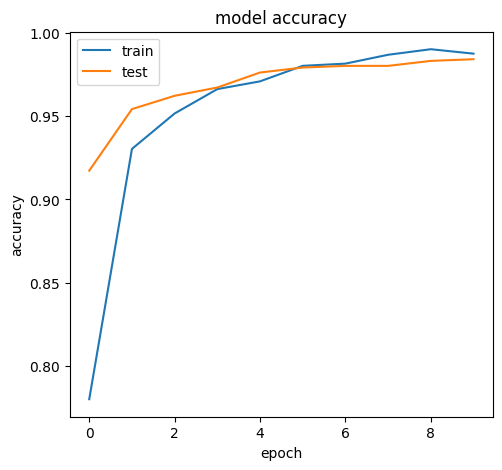

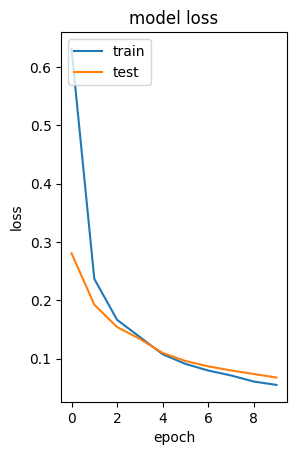

In [ ]:
import matplotlib.pyplot as plt
# Plotting the accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [2]:
! pip install gradio
import gradio as gr

def classify_image(image):
  # Preprocess the image
  image = tf.image.resize(image, (img_height, img_width))
  image = image / 255.0
  image = tf.expand_dims(image, axis=0)

  # Make a prediction
  prediction = model.predict(image)
  predicted_class = class_names[tf.argmax(prediction[0]).numpy()]
  confidence = tf.reduce_max(prediction[0]).numpy()

  return predicted_class, confidence


iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),  # Changed to type="pil" and remove shape
    outputs=[gr.Textbox(label="Predicted Class"), gr.Textbox(label="Confidence")],
    title="Plant Disease Classifier",
    description="Upload an image of a plant leaf to detect its disease.",
)

iface.launch()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public 

In [ ]:
import tensorflow as tf
model.save('/content/drive/MyDrive/save model/inception_resnet_v2_model.h5')